## Getting Started With PyTorch Using Tabular Data

- 참고 : https://www.nickersonj.com/posts/pytorch-tabular/

In [53]:
import torch
from torch import nn

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
# Settings for matplotlib
%matplotlib inline

In [54]:
train = pd.read_csv('data/titanic/train.csv')
test = pd.read_csv('data/titanic/test.csv')

In [55]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [57]:
y_train = train['Survived']
X_train = train.drop('Survived', axis = 1)

In [58]:
X_train.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [59]:
X_train.select_dtypes(include='object')

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S
...,...,...,...,...,...
886,"Montvila, Rev. Juozas",male,211536,NaN,S
887,"Graham, Miss. Margaret Edith",female,112053,B42,S
888,"Johnston, Miss. Catherine Helen ""Carrie""",female,W./C. 6607,NaN,S
889,"Behr, Mr. Karl Howell",male,111369,C148,C


In [60]:
X_train.describe(include=np.number)

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [61]:
X_train.select_dtypes(include=np.number)

,PassengerId,Pclass,Age,SibSp,Parch,Fare
0,1,3,22.0,1,0,7.2500
1,2,1,38.0,1,0,71.2833
2,3,3,26.0,0,0,7.9250
3,4,1,35.0,1,0,53.1000
4,5,3,35.0,0,0,8.0500
...,...,...,...,...,...,...
886,887,2,27.0,0,0,13.0000
887,888,1,19.0,0,0,30.0000
888,889,3,NaN,1,2,23.4500
889,890,1,26.0,0,0,30.0000


In [62]:
def feature_engineering(df):
    
    # The Fare column is skewed, so taking the natural log will make it more even
    df['LogFare'] = np.log1p(df['Fare'])
    
    # Taking the first character of the Cabin column gives the deck, and mapping single characters to groups of decks; other decks will be NaN
    df['DeckGroup'] = df['Cabin'].str[0].map({'A': 'ABC', 'B': 'ABC', 'C':'ABC', 'D':'DE', 'E': 'DE', 'F': 'FG', 'G': 'FG'})

    # Add up all family members
    df['Family'] = df['SibSp'] + df['Parch']
    
    # If the person traveled alone (=1) or has any family members (=0)
    df['Alone'] = (df['Family'] == 0).map({True: 1, False: 0})
    
    # Specify the ticket frequency (how common someone's ticket is)
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    
    # Extract someone's title (e.g., Mr, Mrs, Miss, Rev)
    df['Title'] = df['Name'].str.split(', ', expand=True).iloc[:, 1].str.split('.', expand=True).iloc[:, 0]
    
    # Limit titles to those in the dictionary below; other titles will be NaN
    df['Title'] = df['Title'].map({'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master'})
    
    # Change sex to numbers (male=1, female=0)
    df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
    
    return df


In [63]:
X_train = feature_engineering(X_train)
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,LogFare,DeckGroup,Family,Alone,TicketFreq,Title
0,1,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,2.110213,NaN,1,0,1,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C85,C,4.280593,ABC,1,0,1,Mrs
2,3,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2.188856,NaN,0,1,1,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,C123,S,3.990834,ABC,1,0,2,Mrs
4,5,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,2.202765,NaN,0,1,1,Mr


In [64]:
# 사용 안하는 컬럼 제거
X_train = X_train.drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 
                        'Fare', 'SibSp', 'Parch'], axis=1)

In [65]:
X_train.head()

,Pclass,Sex,Age,Embarked,LogFare,DeckGroup,Family,Alone,TicketFreq,Title
0,3,1,22.0,S,2.110213,NaN,1,0,1,Mr
1,1,0,38.0,C,4.280593,ABC,1,0,1,Mrs
2,3,0,26.0,S,2.188856,NaN,0,1,1,Miss
3,1,0,35.0,S,3.990834,ABC,1,0,2,Mrs
4,3,1,35.0,S,2.202765,NaN,0,1,1,Mr


### Data Cleaning

In [66]:
X_train.isna().sum()

Pclass          0
Sex             0
Age           177
Embarked        2
LogFare         0
DeckGroup     688
Family          0
Alone           0
TicketFreq      0
Title          27
dtype: int64

최빈 값으로 결측치 채우기

In [67]:
X_train.mode()

,Pclass,Sex,Age,Embarked,LogFare,DeckGroup,Family,Alone,TicketFreq,Title
0,3,1,24.0,S,2.202765,ABC,0,1,1,Mr


In [68]:
train_modes = X_train.mode().iloc[0]
train_modes

Pclass               3
Sex                  1
Age               24.0
Embarked             S
LogFare       2.202765
DeckGroup          ABC
Family               0
Alone                1
TicketFreq           1
Title               Mr
Name: 0, dtype: object

In [69]:
def fill_missing(df, modes):
    df = df.fillna(modes)
    return df

In [70]:
X_train = fill_missing(X_train, train_modes)
X_train

,Pclass,Sex,Age,Embarked,LogFare,DeckGroup,Family,Alone,TicketFreq,Title
0,3,1,22.0,S,2.110213,ABC,1,0,1,Mr
1,1,0,38.0,C,4.280593,ABC,1,0,1,Mrs
2,3,0,26.0,S,2.188856,ABC,0,1,1,Miss
3,1,0,35.0,S,3.990834,ABC,1,0,2,Mrs
4,3,1,35.0,S,2.202765,ABC,0,1,1,Mr
...,...,...,...,...,...,...,...,...,...,...
886,2,1,27.0,S,2.639057,ABC,0,1,1,Mr
887,1,0,19.0,S,3.433987,ABC,0,1,1,Miss
888,3,0,24.0,S,3.196630,ABC,3,0,2,Miss
889,1,1,26.0,C,3.433987,ABC,0,1,1,Mr


min-max scaling

In [71]:
def scale_min_max(df, col_name, xmin, xmax):
    df[col_name] = (df[col_name] - xmin) / (xmax - xmin)
    return df

In [72]:
train_age_min = X_train['Age'].min()
train_age_max = X_train['Age'].max()
X_train = scale_min_max(X_train, 'Age', train_age_min, train_age_max)
X_train['Age'].describe()

count    891.000000
mean       0.353694
std        0.165865
min        0.000000
25%        0.271174
50%        0.296306
75%        0.434531
max        1.000000
Name: Age, dtype: float64

카테고리 데이터 확인

In [73]:
X_train.select_dtypes(include='object').columns

Index(['Embarked', 'DeckGroup', 'Title'], dtype='object')

- 여기에 Pclass 추가

In [74]:
def add_dummies(df, cols):
    df = pd.get_dummies(df, columns=cols)
    return df

In [75]:
cols = ['Pclass', 'Embarked', 'DeckGroup', 'Title']
X_train = add_dummies(X_train, cols)

In [76]:
X_train.columns

Index(['Sex', 'Age', 'LogFare', 'Family', 'Alone', 'TicketFreq', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'DeckGroup_ABC', 'DeckGroup_DE', 'DeckGroup_FG', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs'],
      dtype='object')

In [77]:
len(X_train.columns)

19

In [78]:
X_train.head()

,Sex,Age,LogFare,Family,Alone,TicketFreq,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,DeckGroup_ABC,DeckGroup_DE,DeckGroup_FG,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,1,0.271174,2.110213,1,0,1,False,False,True,False,False,True,True,False,False,False,False,True,False
1,0,0.472229,4.280593,1,0,1,True,False,False,True,False,False,True,False,False,False,False,False,True
2,0,0.321438,2.188856,0,1,1,False,False,True,False,False,True,True,False,False,False,True,False,False
3,0,0.434531,3.990834,1,0,2,True,False,False,False,False,True,True,False,False,False,False,False,True
4,1,0.434531,2.202765,0,1,1,False,False,True,False,False,True,True,False,False,False,False,True,False


시험 데이터에도 적용

In [79]:
test_proc = (test.pipe(feature_engineering)
                    .drop(['Name', 'Ticket', 'Cabin', 'PassengerId', 'Fare', 'SibSp', 'Parch'], axis=1)
                    .pipe(fill_missing, train_modes)
                    .pipe(scale_min_max, 'Age', train_age_min, train_age_max)
                    .pipe(add_dummies, cols)
)

test_proc.head()

,Sex,Age,LogFare,Family,Alone,TicketFreq,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,DeckGroup_ABC,DeckGroup_DE,DeckGroup_FG,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,1,0.428248,2.178064,0,1,1,False,False,True,False,True,False,True,False,False,False,False,True,False
1,0,0.585323,2.079442,1,0,1,False,False,True,False,False,True,True,False,False,False,False,False,True
2,1,0.773813,2.369075,0,1,1,False,True,False,False,True,False,True,False,False,False,False,True,False
3,1,0.334004,2.268252,0,1,1,False,False,True,False,False,True,True,False,False,False,False,True,False
4,0,0.271174,2.586824,2,0,1,False,False,True,False,False,True,True,False,False,False,False,False,True


### 모델 학습

텐서로 바꾸기

In [80]:
X_train.iloc[:, 6:].astype('int')

,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,DeckGroup_ABC,DeckGroup_DE,DeckGroup_FG,Title_Master,Title_Miss,Title_Mr,Title_Mrs
0,0,0,1,0,0,1,1,0,0,0,0,1,0
1,1,0,0,1,0,0,1,0,0,0,0,0,1
2,0,0,1,0,0,1,1,0,0,0,1,0,0
3,1,0,0,0,0,1,1,0,0,0,0,0,1
4,0,0,1,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,0,0,0,1,1,0,0,0,0,1,0
887,1,0,0,0,0,1,1,0,0,0,1,0,0
888,0,0,1,0,0,1,1,0,0,0,1,0,0
889,1,0,0,1,0,0,1,0,0,0,0,1,0


In [81]:
X_train.iloc[:, 6:] = X_train.iloc[:, 6:].astype('int') # bool은 전환안됨

In [82]:
X = torch.tensor(X_train.values, dtype= torch.float32)
y = torch.tensor(y_train.values, dtype = torch.float32)

데이터 나누기

In [83]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, shuffle=True)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_valid:', X_valid.shape)
print('y_valid:', y_valid.shape)

X_train: torch.Size([668, 19])
y_train: torch.Size([668])
X_valid: torch.Size([223, 19])
y_valid: torch.Size([223])


In [84]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

모델 만들기

In [85]:
class TitanicModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(19, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 96)
        self.linear4 = nn.Linear(96, 32)
        self.linear5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
    def forward(self, x):
        return self.linear5(self.relu(self.linear4(self.dropout(self.relu(self.linear3(self.dropout(self.relu(self.linear2(self.dropout(self.relu(self.linear1(x))))))))))))


In [86]:
model = TitanicModel().to(device)
model

TitanicModel(
  (linear1): Linear(in_features=19, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=96, bias=True)
  (linear4): Linear(in_features=96, out_features=32, bias=True)
  (linear5): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.25, inplace=False)
)

In [87]:
learning_rate = 0.003

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=learning_rate)

forward pass 진행해보기

In [90]:
logits = model(X_train)
logits[:5]

tensor([[0.0307],
        [0.0412],
        [0.0194],
        [0.0497],
        [0.0149]], grad_fn=<SliceBackward0>)

In [93]:
# Logits -> Probabilities b/n 0 and 1 -> Rounded to 0 or 1
pred_probab = torch.round(torch.sigmoid(logits))
print('probabilities:', pred_probab[0:5])

probabilities: tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<SliceBackward0>)


accuracy 함수

In [95]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

모델 학습

In [96]:
# Number of epochs
epochs = 10000

# Send data to the device
X_train, X_valid = X_train.to(device), X_valid.to(device)
y_train, y_valid = y_train.to(device), y_valid.to(device)

# Empty loss lists to track values
epoch_count, train_loss_values, valid_loss_values = [], [], []

In [97]:
for epoch in range(epochs):

    # Put the model in training mode
    model.train()

    y_logits = model(X_train).squeeze() # forward pass to get predictions; squeeze the logits into the same shape as the labels
    y_pred = torch.round(torch.sigmoid(y_logits)) # convert logits into prediction probabilities

    loss = loss_fn(y_logits, y_train) # compute the loss   
    acc = accuracy_fn(y_train.int(), y_pred) # calculate the accuracy; convert the labels to integers

    optimizer.zero_grad() # reset the gradients so they don't accumulate each iteration
    loss.backward() # backward pass: backpropagate the prediction loss
    optimizer.step() # gradient descent: adjust the parameters by the gradients collected in the backward pass
    
    # Put the model in evaluation mode
    model.eval() 

    with torch.inference_mode():
        valid_logits = model(X_valid).squeeze()
        valid_pred = torch.round(torch.sigmoid(valid_logits))    

        valid_loss = loss_fn(valid_logits, y_valid)
        valid_acc = accuracy_fn(y_valid.int(), valid_pred)    
    
    # Print progress a total of 20 times
    if epoch % int(epochs / 20) == 0:
        print(f'Epoch: {epoch:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')

        epoch_count.append(epoch)
        train_loss_values.append(loss.detach().numpy())
        valid_loss_values.append(valid_loss.detach().numpy())

Epoch:    0 | Train Loss: 0.69749, Accuracy: 38.17% | Validation Loss: 0.69683, Accuracy: 39.46%
Epoch:  500 | Train Loss: 0.67569, Accuracy: 61.98% | Validation Loss: 0.67763, Accuracy: 60.54%
Epoch: 1000 | Train Loss: 0.66717, Accuracy: 61.98% | Validation Loss: 0.67113, Accuracy: 60.54%
Epoch: 1500 | Train Loss: 0.66462, Accuracy: 61.98% | Validation Loss: 0.66862, Accuracy: 60.54%
Epoch: 2000 | Train Loss: 0.66286, Accuracy: 61.98% | Validation Loss: 0.66716, Accuracy: 60.54%
Epoch: 2500 | Train Loss: 0.66062, Accuracy: 61.98% | Validation Loss: 0.66566, Accuracy: 60.54%
Epoch: 3000 | Train Loss: 0.65777, Accuracy: 61.98% | Validation Loss: 0.66363, Accuracy: 60.54%
Epoch: 3500 | Train Loss: 0.65766, Accuracy: 61.98% | Validation Loss: 0.66066, Accuracy: 60.54%
Epoch: 4000 | Train Loss: 0.65204, Accuracy: 61.98% | Validation Loss: 0.65646, Accuracy: 60.54%
Epoch: 4500 | Train Loss: 0.64753, Accuracy: 61.98% | Validation Loss: 0.65036, Accuracy: 60.54%
Epoch: 5000 | Train Loss: 0.64

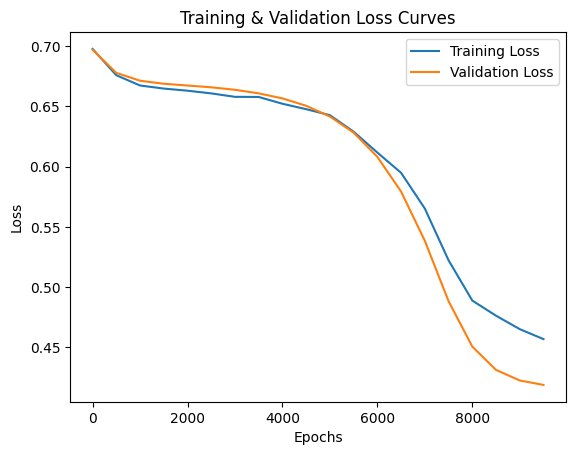

In [98]:
plt.plot(epoch_count, train_loss_values, label='Training Loss')
plt.plot(epoch_count, valid_loss_values, label='Validation Loss')
plt.title('Training & Validation Loss Curves')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [99]:
# Create a directory for models
MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create a model save path 
MODEL_NAME = 'pytorch_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

### Inference & Submission

데이터를 텐서로 바꾸기

In [103]:
test_proc.iloc[:, 6:] = test_proc.iloc[:, 6:].astype('int')

In [104]:
X_test = torch.tensor(test_proc.values, dtype=torch.float32)
type(X_test)

torch.Tensor

예측

In [106]:
model.eval()

with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits)).int()
    
test_pred.shape, test_pred[:5]

(torch.Size([418]), tensor([0, 1, 0, 0, 1], dtype=torch.int32))